In [1]:
"""
Process Name : STEP 4 : TRAINING DATA WITH PERSONALITY FEATURE
"""
#=======================================================================================================
### Required Imports ###
#============================================================================================================
try:
    import sys  # System-specific parameters and functions
    import logging # for logs
    from datetime import datetime  # Date and time
    import socket # network communication
    import warnings  # Warning control
    import os # Interacting with the operating system
    import pandas as pd  # Data manipulation
    import numpy as np  # Numerical operations
    from sklearn.utils import resample  # Resampling utilities
    from imblearn.over_sampling import SMOTE  # Oversampling for imbalanced data
    from sklearn.ensemble import RandomForestClassifier  # Random Forest classifier
    import lightgbm as lgb  # LightGBM for boosting
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # Model evaluation metrics
    from sklearn.multioutput import MultiOutputClassifier  # Multi-output classifier wrapper
    from sklearn.model_selection import train_test_split  # Split dataset
    from sklearn.preprocessing import LabelEncoder  # Encode labels as integers
    from sklearn.cluster import KMeans  # K-means clustering
    from sklearn.preprocessing import StandardScaler  # Feature standardization
    import matplotlib.pyplot as plt  # Plotting
    from sklearn.preprocessing import MinMaxScaler  # Feature scaling
    from tensorflow.keras.models import Sequential  # Keras Sequential model
    from tensorflow.keras.callbacks import EarlyStopping  # Early stopping callback
    from sklearn.metrics import silhouette_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score  # Various metrics
    from sklearn.ensemble import RandomForestRegressor  # Random Forest regressor
    from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense  # CNN layers
except Exception as err:
    print("Exception raised while importing the packages")
    print(f'Exception: {err}')
    #input("press Enter to Close")
    sys.exit()

2024-09-05 15:41:42.389882: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#=========================================================================
### Initialization ###
#=========================================================================
try:
    path = os.getcwd()
    curr_time = datetime.now()

    ### Log Files declaration ###
    log_folder = os.path.join(path, 'Logs')
    log_date_fmt = str(curr_time.strftime('%Y')) + '-' + str(curr_time.strftime('%m')) + '-' + str(curr_time.strftime('%d')) + "_" + str(curr_time.strftime("%H")) + "-" + str(curr_time.strftime("%M"))

    audit_log_file = "Audit_training_evaluation_personality.log"
    audit_log_file = os.path.join(log_folder, audit_log_file)
    
    error_log_file = "Error_training_evaluation_personality.log"
    error_log_file = os.path.join(log_folder, error_log_file)

    ### Creating log folder ###
    if not os.path.exists(log_folder):
        os.makedirs(log_folder)
        
    ### Function: Logger setup ###
    def setup_logger(logger_name, log_file, level=logging.INFO):
        logger = logging.getLogger(logger_name)
        formatter = logging.Formatter(socket.gethostname()+' : '+'%(asctime)s : %(levelname)s : [%(filename)s:%(lineno)d] : %(message)s')

        fileHandler = logging.FileHandler(log_file, mode='w')

        fileHandler.setFormatter(formatter)

        streamHandler = logging.StreamHandler(sys.stdout)
        streamHandler.setFormatter(formatter)

        logger.setLevel(level)
        logger.addHandler(fileHandler)
        logger.addHandler(streamHandler)
        return logger
        
    ### Setting up the logger ###
    setup_logger('audit', audit_log_file, level=logging.INFO)
    setup_logger('error', error_log_file, level=logging.ERROR)

    audit_logger = logging.getLogger('audit')
    error_logger = logging.getLogger('error')

    audit_logger.info('Process start')

except Exception as err:
    print('Setting up the logger failed')
    print(f'Exception: {err}')
    #input("press Enter to Close")
    sys.exit()

192.168.1.112 : 2024-09-05 15:41:44,399 : INFO : [1318943869.py:46] : Process start


In [3]:
#==================================================================================================
### Ignore Warnings ### 
#==================================================================================================
try:
    audit_logger.info('Ignore Warnings')
    warnings.filterwarnings('ignore') ## Suppress all warnings
except Exception as err:
    audit_logger.info('Ignore Warnings - Failed')
    error_logger.error('Ignore Warnings - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()

192.168.1.112 : 2024-09-05 15:41:44,405 : INFO : [2561458356.py:5] : Ignore Warnings


In [4]:
#==================================================================================================
### Create folder structure ### 
#==================================================================================================
try:
    audit_logger.info('Create folder structure')
    excel_folder = os.path.join(path, 'Excel_files')
    if not os.path.isdir(excel_folder):
        os.mkdir(excel_folder)
    saved_folder = os.path.join(path, 'Saved_files')
    if not os.path.isdir(saved_folder):
        os.mkdir(saved_folder)
    output_folder = os.path.join(path, 'Output')
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)
except Exception as err:
    audit_logger.info('Create folder structure - Failed')
    error_logger.error('Create folder structure - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()

192.168.1.112 : 2024-09-05 15:41:44,411 : INFO : [4180990911.py:5] : Create folder structure


192.168.1.112 : 2024-09-05 15:41:44,426 : INFO : [507812218.py:5] : Cluster formation and applying smote and split


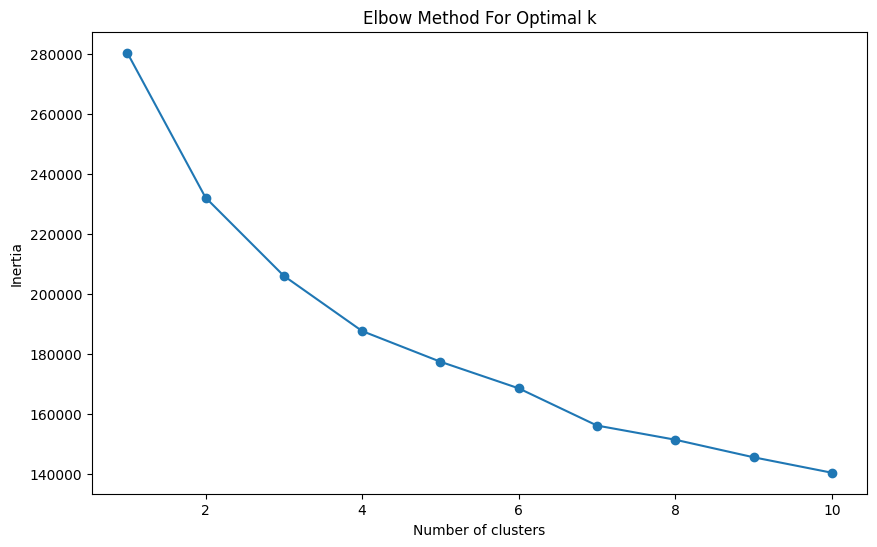

192.168.1.112 : 2024-09-05 15:41:54,330 : INFO : [507812218.py:43] : Silhouette Score: 0.234
192.168.1.112 : 2024-09-05 15:41:54,365 : INFO : [507812218.py:51] : Length of data before SMOTE: 13196
192.168.1.112 : 2024-09-05 15:41:54,435 : INFO : [507812218.py:63] : Length of data after smote: 21284


In [5]:
#==================================================================================================
### Cluster formation and applying smote and split ### 
#==================================================================================================
try:
    audit_logger.info('Cluster formation and applying smote and split')
    df = pd.read_excel(os.path.join(excel_folder, "preprocessed_data.xlsx"))
    eval_df = pd.read_excel(os.path.join(excel_folder,"evaluation_data_preprocessed.xlsx"))
    
    data_for_cluster = df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                           'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
                           'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon', 
                           'resi_lat', 'resi_lon', 'Age', "Personality"]]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data_for_cluster)
    
    # Determine the optimal number of clusters using the Elbow Method
    inertia = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)
    
    # Plotting the Elbow Curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), inertia, marker='o')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.savefig(os.path.join(saved_folder,'elbow_method_without_personality.png'), format='png', dpi=300) 
    plt.show()
    
    # Choose the optimal number of clusters
    k_optimal = 2
    kmeans = KMeans(n_clusters=k_optimal, random_state=42)
    kmeans.fit(X_scaled)
    clusters = kmeans.predict(X_scaled)
    
    # Add the cluster labels to your original dataframe
    data_for_cluster['Cluster'] = clusters
    df['Cluster'] = clusters

    score = silhouette_score(X_scaled, clusters)
    audit_logger.info('Silhouette Score: %.3f' % score)

    df.fillna(0, inplace=True)
    df=df.drop_duplicates()
    
    # Perform stratified train-test split
    X, y = df.drop('Preferred_Clothing', axis=1), df['Preferred_Clothing']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
    audit_logger.info(f'Length of data before SMOTE: {len(X_train)}')
    
    # Apply SMOTE
    sm = SMOTE(random_state=123)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    # Combine resampled data back into a DataFrame
    df_resampled = pd.DataFrame(X_res, columns=X.columns)
    df_resampled['Preferred_Clothing'] = y_res
    df_resampled.drop_duplicates(inplace=True)
    df_resampled.fillna(0, inplace=True)
    
    train_df=df_resampled.drop_duplicates()
    audit_logger.info(f'Length of data after smote: {len(train_df)}')  
    
    test_df = pd.concat([X_test, y_test], axis=1)
except Exception as err:
    audit_logger.info('Cluster formation and applying smote and split - Failed')
    error_logger.error('Cluster formation and applying smote and split - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()

In [6]:
#==================================================================================================
### Train Test for Preferred_clothing ### 
#==================================================================================================
try:
    audit_logger.info('Train Test for Preferred_clothing')
    df_preferred_clothing_train = train_df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
                       'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon', 'Cluster',
                       'resi_lat', 'resi_lon', 'Age', 'Preferred_Clothing', 'Personality']]
    df_preferred_clothing_train.drop_duplicates(inplace=True)
    audit_logger.info(f'Training data size: {len(df_preferred_clothing_train)}')
    df_preferred_clothing_test = test_df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                           'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
                           'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon', 'Cluster',
                           'resi_lat', 'resi_lon', 'Age', 'Preferred_Clothing', 'Personality']]
    X_train_1 = df_preferred_clothing_train[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                           'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Cluster',
                           'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon', 
                           'resi_lat', 'resi_lon', 'Age', 'Personality']]
    X_test_1 = df_preferred_clothing_test[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                           'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Cluster',
                           'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon', 
                           'resi_lat', 'resi_lon', 'Age', 'Personality']]
    
    y_train_1 = df_preferred_clothing_train["Preferred_Clothing"]
    y_test_1 = df_preferred_clothing_test["Preferred_Clothing"]
    # Initialize and train RandomForest
    rf_model = RandomForestClassifier(criterion= 'gini', max_depth= None, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 250 , 
                                      random_state=42)
    rf_model.fit(X_train_1, y_train_1)
    # Initialize and train LightGBM
    lgb_model = lgb.LGBMClassifier(boosting_type='dart', learning_rate=0.8, max_depth=12, n_estimators=200, num_leaves=158, subsample=0.4)
    lgb_model.fit(X_train_1, y_train_1)
    
    # Predict probabilities for the test set
    rf_probs = rf_model.predict_proba(X_test_1)[:, 1]  
    lgb_probs = lgb_model.predict_proba(X_test_1)[:, 1]
    # Blend the predictions by averaging
    blended_probs = (rf_probs + lgb_probs) / 2
    # Convert probabilities to final predictions based on a threshold
    final_predictions_test = (blended_probs > 0.50).astype(int)
    # Evaluate the blended model
    accuracy = accuracy_score(y_test, final_predictions_test)
    precision = precision_score(y_test, final_predictions_test, average='binary')  
    recall = recall_score(y_test, final_predictions_test, average='binary')       
    f1 = f1_score(y_test, final_predictions_test, average='binary') 
    audit_logger.info("Blended Model Accuracy: %.4f%%" % (accuracy * 100.0))
    audit_logger.info("Precision: %.4f" % (precision * 100.0))
    audit_logger.info("Recall: %.4f" % (recall * 100.0))
    audit_logger.info("F1 Score: %.4f" % (f1 * 100))
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test_1, final_predictions_test)
    audit_logger.info("Confusion Matrix:" % cm)
    
    # Extracting TP, TN, FP, FN
    tn, fp, fn, tp = cm.ravel()
    audit_logger.info(f"True Positives (TP): {tp}")
    audit_logger.info(f"False Positives (FP): {fp}")
    audit_logger.info(f"True Negatives (TN): {tn}")
    audit_logger.info(f"False Negatives (FN): {fn}")
except Exception as err:
    audit_logger.info('Train Test for Preferred_clothing - Failed')
    error_logger.error('Train Test for Preferred_clothing - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()

192.168.1.112 : 2024-09-05 15:41:54,453 : INFO : [3299243014.py:5] : Train Test for Preferred_clothing
192.168.1.112 : 2024-09-05 15:41:54,466 : INFO : [3299243014.py:11] : Training data size: 10187
[LightGBM] [Info] Number of positive: 2133, number of negative: 8054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2910
[LightGBM] [Info] Number of data points in the train set: 10187, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209385 -> initscore=-1.328639
[LightGBM] [Info] Start training from score -1.328639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [7]:
train_df.columns

Index(['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type',
       'Personality', 'Clothing_Size', 'Favourite_Color_r',
       'Favourite_Color_g', 'Favourite_Color_b', 'Best_Color_Confidence_r',
       'Best_Color_Confidence_g', 'Best_Color_Confidence_b',
       'Preferred_Bottoms', 'Bottoms_Material', 'Bottoms_Length',
       'Bottoms_Fitting', 'Bottoms_Color_r', 'Bottoms_Color_g',
       'Bottoms_Color_b', 'Preferred_Upperwear', 'Upperwear_Material',
       'Upperwear_Length', 'Upperwear_Neckline', 'Upperwear_Sleeve_Type',
       'Upperwear_Pattern', 'Upperwear_Color_r', 'Upperwear_Color_g',
       'Upperwear_Color_b', 'Favourite_Single_Piece', 'Single_Piece_Material',
       'Single_Piece_Fitting', 'Single_Piece_Length', 'Single_Piece_Sleeves',
       'Single_Piece_Neckline', 'Single_Piece_Pattern', 'Single_Piece_Color_r',
       'Single_Piece_Color_g', 'Single_Piece_Color_b', 'birthplace_lat',
       'birthplace_lon', 'resi_lat', 'resi_lon', 'Age', 'Cluster',
       'Pre

In [8]:
#==================================================================================================
### Evaluation for Preferred_clothing ### 
#==================================================================================================
try:
    audit_logger.info('Evaluation for Preferred_clothing')
    data_for_cluster_eval = eval_df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                           'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
                           'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon',
                           'resi_lat', 'resi_lon', 'Age', 'Personality']]
    
    X_eval_scaled = scaler.transform(data_for_cluster_eval)
    eval_df['Cluster'] = kmeans.predict(X_eval_scaled)
    X_eval = eval_df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                           'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Cluster',
                           'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon', 
                           'resi_lat', 'resi_lon', 'Age', 'Personality']]
    y_eval = eval_df[['Preferred_Clothing']]
    # Predict probabilities for the test set
    rf_probs = rf_model.predict_proba(X_eval)[:, 1]  
    lgb_probs = lgb_model.predict_proba(X_eval)[:, 1]
    # Blend the predictions by averaging
    blended_probs = (rf_probs + lgb_probs) / 2
    # Convert probabilities to final predictions based on a threshold
    final_predictions_eval = (blended_probs > 0.50).astype(int)
    # Evaluate the blended model
    accuracy = accuracy_score(y_eval, final_predictions_eval)
    precision = precision_score(y_eval, final_predictions_eval, average='binary')  
    recall = recall_score(y_eval, final_predictions_eval, average='binary')        
    f1 = f1_score(y_eval, final_predictions_eval, average='binary')                
    audit_logger.info("Blended Model Accuracy: %.4f%%" % (accuracy * 100.0))
    audit_logger.info("Precision: %.4f" % (precision * 100.0))
    audit_logger.info("Recall: %.4f" % (recall * 100.0))
    audit_logger.info("F1 Score: %.4f" % (f1 * 100))
    # Calculate confusion matrix
    cm = confusion_matrix(y_eval, final_predictions_eval)
    audit_logger.info("Confusion Matrix:" % cm)
    # Extracting TP, TN, FP, FN
    tn, fp, fn, tp = cm.ravel()
    audit_logger.info(f"True Positives (TP): {tp}")
    audit_logger.info(f"False Positives (FP): {fp}")
    audit_logger.info(f"True Negatives (TN): {tn}")
    audit_logger.info(f"False Negatives (FN): {fn}")
except Exception as err:
    audit_logger.info('Evaluation for Preferred_clothing - Failed')
    error_logger.error('Evaluation for Preferred_clothing - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()  

192.168.1.112 : 2024-09-05 15:41:58,294 : INFO : [1453635542.py:5] : Evaluation for Preferred_clothing
192.168.1.112 : 2024-09-05 15:41:58,343 : INFO : [1453635542.py:35] : Blended Model Accuracy: 86.0335%
192.168.1.112 : 2024-09-05 15:41:58,344 : INFO : [1453635542.py:36] : Precision: 93.4343
192.168.1.112 : 2024-09-05 15:41:58,344 : INFO : [1453635542.py:37] : Recall: 91.0209
192.168.1.112 : 2024-09-05 15:41:58,344 : INFO : [1453635542.py:38] : F1 Score: 92.2118
192.168.1.112 : 2024-09-05 15:41:58,347 : INFO : [1453635542.py:42] : Confusion Matrix:
192.168.1.112 : 2024-09-05 15:41:58,348 : INFO : [1453635542.py:46] : True Positives (TP): 740
192.168.1.112 : 2024-09-05 15:41:58,348 : INFO : [1453635542.py:47] : False Positives (FP): 52
192.168.1.112 : 2024-09-05 15:41:58,349 : INFO : [1453635542.py:48] : True Negatives (TN): 30
192.168.1.112 : 2024-09-05 15:41:58,349 : INFO : [1453635542.py:49] : False Negatives (FN): 73


In [9]:
#==================================================================================================
### Divide data for one piece wear and two piece wear ### 
#==================================================================================================
try:
    audit_logger.info('Divide data for one piece wear and two piece wear')
    # Convert y_pred to a DataFrame or Series
    y_pred_series = pd.Series(final_predictions_test, name='pred_Preferred_Clothing')
    
    # Ensure the indices match if they are not reset
    test_df = test_df.reset_index(drop=True)
    y_pred_series = y_pred_series.reset_index(drop=True)
    
    # Combine the predictions with the test DataFrame
    df_with_predictions = pd.concat([test_df, y_pred_series], axis=1) 
    df_with_piecewear_test = df_with_predictions[df_with_predictions["Preferred_Clothing"] == df_with_predictions["pred_Preferred_Clothing"]]
    
    # Convert y_pred to a DataFrame or Series
    y_pred_series = pd.Series(final_predictions_eval, name='pred_Preferred_Clothing')
    
    # Ensure the indices match if they are not reset
    eval_df = eval_df.reset_index(drop=True)
    y_pred_series = y_pred_series.reset_index(drop=True)
    
    # Combine the predictions with the test DataFrame
    eval_df_with_predictions = pd.concat([eval_df, y_pred_series], axis=1) 
    df_with_piecewear_eval = eval_df_with_predictions[eval_df_with_predictions["Preferred_Clothing"] == eval_df_with_predictions["pred_Preferred_Clothing"]]
except Exception as err:
    audit_logger.info('Divide data for one piece wear and two piece wear - Failed')
    error_logger.error('Divide data for one piece wear and two piece wear - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit() 


192.168.1.112 : 2024-09-05 15:41:58,359 : INFO : [3368686975.py:5] : Divide data for one piece wear and two piece wear


In [10]:
#==================================================================================================
### Train test classifier for two piece wear ### 
#==================================================================================================
try:
    audit_logger.info('Train test classifier for two piece wear')
    df_twopiece_test = df_with_piecewear_test[df_with_piecewear_test["Preferred_Clothing"] == 1]
    
    X_twopiece_test = df_twopiece_test[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
              'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
              'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
    y_twopiece_test = df_twopiece_test[['Preferred_Bottoms', 'Bottoms_Material','Bottoms_Length', 'Bottoms_Fitting', 'Preferred_Upperwear',
           'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline','Upperwear_Sleeve_Type', 'Upperwear_Pattern']]
    
    df_twopiece_train = train_df[train_df["Preferred_Clothing"] == 1]
    df_twopiece_train = df_twopiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
              'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
              'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age', 
                'Preferred_Bottoms', 'Bottoms_Material','Bottoms_Length', 'Bottoms_Fitting', 'Preferred_Upperwear',
           'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline','Upperwear_Sleeve_Type', 'Upperwear_Pattern']]
    df_twopiece_train.drop_duplicates(inplace=True)
    audit_logger.info(f'Training data size: {len(df_twopiece_train)}')
    X_twopiece_train = df_twopiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
              'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
              'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
    y_twopiece_train = df_twopiece_train[['Preferred_Bottoms', 'Bottoms_Material','Bottoms_Length', 'Bottoms_Fitting', 'Preferred_Upperwear',
           'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline','Upperwear_Sleeve_Type', 'Upperwear_Pattern']]
    
    # Initialize a Random Forest Classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='entropy', random_state=42)
    # Wrap it in the MultiOutputClassifier
    multi_rf_classifier = MultiOutputClassifier(rf_classifier)
    
    # Training the classifier
    multi_rf_classifier.fit(X_twopiece_train, y_twopiece_train)
    
    # Predicting the test set results
    y_pred_test = multi_rf_classifier.predict(X_twopiece_test)

    # Lists to store metrics for each label
    accuracies = []
    macro_precisions = []
    macro_recalls = []
    macro_f1_scores = []
    micro_precisions = []
    micro_recalls = []
    micro_f1_scores = []
    
    # Iterate over each target column
    for i in range(y_twopiece_test.shape[1]):
        accuracies.append(accuracy_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i]))
        macro_precisions.append(precision_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i], average="macro", zero_division=0))
        macro_recalls.append(recall_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i], average="macro", zero_division=0))
        macro_f1_scores.append(f1_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i], average="macro", zero_division=0))
        micro_precisions.append(precision_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i], average="micro", zero_division=0))
        micro_recalls.append(recall_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i], average="micro", zero_division=0))
        micro_f1_scores.append(f1_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i], average="micro", zero_division=0))
        
    # Output the calculated metrics for each target
    for i, column in enumerate(y_twopiece_test.columns):
        audit_logger.info(f"Metrics for {column}:")
        audit_logger.info(f"  Accuracy: {accuracies[i]:.4f}")
        audit_logger.info(f"  Macro Precision: {macro_precisions[i]:.4f}")
        audit_logger.info(f"  Macro Recall: {macro_recalls[i]:.4f}")
        audit_logger.info(f"  Macro F1 Score: {macro_f1_scores[i]:.4f}")
        audit_logger.info(f"  Micro Precision: {micro_precisions[i]:.4f}")
        audit_logger.info(f"  Micro Recall: {micro_recalls[i]:.4f}")
        audit_logger.info(f"  Micro F1 Score: {micro_f1_scores[i]:.4f}")
        audit_logger.info("\n" + "-"*80 + "\n")
    
    # Calculate overall metrics by averaging
    overall_accuracy = sum(accuracies) / len(accuracies)
    overall_macro_precision = sum(macro_precisions) / len(macro_precisions)
    overall_macro_recall = sum(macro_recalls) / len(macro_recalls)
    overall_macro_f1 = sum(macro_f1_scores) / len(macro_f1_scores)
    overall_micro_precision = sum(micro_precisions) / len(micro_precisions)
    overall_micro_recall = sum(micro_recalls) / len(micro_recalls)
    overall_micro_f1 = sum(micro_f1_scores) / len(micro_f1_scores)
    
    audit_logger.info("\nOverall Metrics:")
    audit_logger.info(f"  Overall Accuracy: {overall_accuracy:.4f}")
    audit_logger.info(f"  Overall Macro Precision: {overall_macro_precision:.4f}")
    audit_logger.info(f"  Overall Macro Recall: {overall_macro_recall:.4f}")
    audit_logger.info(f"  Overall Macro F1 Score: {overall_macro_f1:.4f}")
    audit_logger.info(f"  Overall Micro Precision: {overall_micro_precision:.4f}")
    audit_logger.info(f"  Overall Micro Recall: {overall_micro_recall:.4f}")
    audit_logger.info(f"  Overall Micro F1 Score: {overall_micro_f1:.4f}")

    #Adding values in the common dataframe
    column_name = ["pred_"+col for col in y_twopiece_test.columns]
    y_pred_df = pd.DataFrame(y_pred_test, columns=column_name, index=y_twopiece_test.index)
    df_with_predictions = pd.merge(df_with_predictions, y_pred_df, left_index=True, right_index=True, how='left')
except Exception as err:
    audit_logger.info('Train test classifier for two piece wear - Failed')
    error_logger.error('Train test classifier for two piece wear - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit() 

192.168.1.112 : 2024-09-05 15:41:58,388 : INFO : [3647212635.py:5] : Train test classifier for two piece wear
192.168.1.112 : 2024-09-05 15:41:58,398 : INFO : [3647212635.py:21] : Training data size: 4401
192.168.1.112 : 2024-09-05 15:42:05,536 : INFO : [3647212635.py:60] : Metrics for Preferred_Bottoms:
192.168.1.112 : 2024-09-05 15:42:05,538 : INFO : [3647212635.py:61] :   Accuracy: 0.8883
192.168.1.112 : 2024-09-05 15:42:05,539 : INFO : [3647212635.py:62] :   Macro Precision: 0.9079
192.168.1.112 : 2024-09-05 15:42:05,539 : INFO : [3647212635.py:63] :   Macro Recall: 0.9001
192.168.1.112 : 2024-09-05 15:42:05,539 : INFO : [3647212635.py:64] :   Macro F1 Score: 0.9024
192.168.1.112 : 2024-09-05 15:42:05,540 : INFO : [3647212635.py:65] :   Micro Precision: 0.8883
192.168.1.112 : 2024-09-05 15:42:05,540 : INFO : [3647212635.py:66] :   Micro Recall: 0.8883
192.168.1.112 : 2024-09-05 15:42:05,540 : INFO : [3647212635.py:67] :   Micro F1 Score: 0.8883
192.168.1.112 : 2024-09-05 15:42:05,5

In [11]:
#==================================================================================================
### Evaluation for two piece wear classifier ### 
#==================================================================================================
try:
    audit_logger.info('Evaluation for two piece wear classifier')
    df_twopiece_eval = df_with_piecewear_eval[df_with_piecewear_eval["Preferred_Clothing"] == 1]
    
    X_twopiece_eval = df_twopiece_eval[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
              'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
              'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
    y_twopiece_eval = df_twopiece_eval[['Preferred_Bottoms', 'Bottoms_Material','Bottoms_Length', 'Bottoms_Fitting', 'Preferred_Upperwear',
           'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline','Upperwear_Sleeve_Type', 'Upperwear_Pattern']]
    
    # Predicting the test set results
    y_pred_eval = multi_rf_classifier.predict(X_twopiece_eval)
    
    # Initialize lists to store the metrics for each target
    accuracies = []
    macro_precisions = []
    macro_recalls = []
    macro_f1_scores = []
    micro_precisions = []
    micro_recalls = []
    micro_f1_scores = []
    
    # Iterate over each target column
    for i in range(y_twopiece_eval.shape[1]):
        accuracies.append(accuracy_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i]))
        macro_precisions.append(precision_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i], average='macro', zero_division=0))
        macro_recalls.append(recall_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i], average='macro', zero_division=0))
        macro_f1_scores.append(f1_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i], average='macro', zero_division=0))
        micro_precisions.append(precision_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i], average='micro', zero_division=0))
        micro_recalls.append(recall_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i], average='micro', zero_division=0))
        micro_f1_scores.append(f1_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i], average='micro', zero_division=0))
    
    # Output the calculated metrics for each target
    for i, column in enumerate(y_twopiece_train.columns):
        audit_logger.info(f"Metrics for {column}:")
        audit_logger.info(f"  Accuracy: {accuracies[i]:.4f}")
        audit_logger.info(f"  Macro Precision: {macro_precisions[i]:.4f}")
        audit_logger.info(f"  Macro Recall: {macro_recalls[i]:.4f}")
        audit_logger.info(f"  Macro F1 Score: {macro_f1_scores[i]:.4f}")
        audit_logger.info(f"  Micro Precision: {micro_precisions[i]:.4f}")
        audit_logger.info(f"  Micro Recall: {micro_recalls[i]:.4f}")
        audit_logger.info(f"  Micro F1 Score: {micro_f1_scores[i]:.4f}")
        audit_logger.info("\n" + "-"*80 + "\n")
    
    # Calculate overall metrics by averaging
    average_accuracy = sum(accuracies) / len(accuracies)
    average_macro_precision = sum(macro_precisions) / len(macro_precisions)
    average_macro_recall = sum(macro_recalls) / len(macro_recalls)
    average_macro_f1 = sum(macro_f1_scores) / len(macro_f1_scores)
    average_micro_precision = sum(micro_precisions) / len(micro_precisions)
    average_micro_recall = sum(micro_recalls) / len(micro_recalls)
    average_micro_f1 = sum(micro_f1_scores) / len(micro_f1_scores)
    
    audit_logger.info("\nOverall Metrics:")
    audit_logger.info(f"  Overall Accuracy: {overall_accuracy:.4f}")
    audit_logger.info(f"  Overall Macro Precision: {overall_macro_precision:.4f}")
    audit_logger.info(f"  Overall Macro Recall: {overall_macro_recall:.4f}")
    audit_logger.info(f"  Overall Macro F1 Score: {overall_macro_f1:.4f}")
    audit_logger.info(f"  Overall Micro Precision: {overall_micro_precision:.4f}")
    audit_logger.info(f"  Overall Micro Recall: {overall_micro_recall:.4f}")
    audit_logger.info(f"  Overall Micro F1 Score: {overall_micro_f1:.4f}")

    #Adding values in the common dataframe
    column_name = ["pred_"+col for col in y_twopiece_eval.columns]
    y_pred_df = pd.DataFrame(y_pred_eval, columns=column_name, index=y_twopiece_eval.index)
    eval_df_with_predictions = pd.merge(eval_df_with_predictions, y_pred_df, left_index=True, right_index=True, how='left')
except Exception as err:
    audit_logger.info('Evaluation for two piece wear classifier - Failed')
    error_logger.error('Evaluation for two piece wear classifier - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()    


192.168.1.112 : 2024-09-05 15:42:05,630 : INFO : [3450908091.py:5] : Evaluation for two piece wear classifier
192.168.1.112 : 2024-09-05 15:42:05,857 : INFO : [3450908091.py:38] : Metrics for Preferred_Bottoms:
192.168.1.112 : 2024-09-05 15:42:05,858 : INFO : [3450908091.py:39] :   Accuracy: 0.4554
192.168.1.112 : 2024-09-05 15:42:05,858 : INFO : [3450908091.py:40] :   Macro Precision: 0.1529
192.168.1.112 : 2024-09-05 15:42:05,858 : INFO : [3450908091.py:41] :   Macro Recall: 0.1214
192.168.1.112 : 2024-09-05 15:42:05,859 : INFO : [3450908091.py:42] :   Macro F1 Score: 0.1050
192.168.1.112 : 2024-09-05 15:42:05,859 : INFO : [3450908091.py:43] :   Micro Precision: 0.4554
192.168.1.112 : 2024-09-05 15:42:05,859 : INFO : [3450908091.py:44] :   Micro Recall: 0.4554
192.168.1.112 : 2024-09-05 15:42:05,859 : INFO : [3450908091.py:45] :   Micro F1 Score: 0.4554
192.168.1.112 : 2024-09-05 15:42:05,860 : INFO : [3450908091.py:46] : 
-------------------------------------------------------------

In [12]:
#==================================================================================================
### Deeplearning model for two piece wear color### 
#==================================================================================================
try:
    audit_logger.info('Train test regressor for two piece wear')

    # Data preparation (assuming the code to prepare df_color_twopiece_train and df_twopiece_test is the same as before)
    X_color_twopiece_test = df_twopiece_test[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
               'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
               'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
    y_color_twopiece_test = df_twopiece_test[['Preferred_Bottoms', 'Bottoms_Color_r', 'Bottoms_Color_g','Bottoms_Color_b', 'Preferred_Upperwear',
           'Upperwear_Color_r', 'Upperwear_Color_g', 'Upperwear_Color_b']]
    df_color_twopiece_train = train_df[train_df["Preferred_Clothing"] == 1]
    df_color_twopiece_train = df_color_twopiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
               'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
               'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age', 
                'Preferred_Bottoms', 'Bottoms_Color_r', 'Bottoms_Color_g','Bottoms_Color_b', 'Preferred_Upperwear',
           'Upperwear_Color_r', 'Upperwear_Color_g', 'Upperwear_Color_b']]
    df_color_twopiece_train.drop_duplicates(inplace=True)
    X_color_twopiece_train = df_color_twopiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
               'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
               'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
    y_color_twopiece_train = df_color_twopiece_train[['Preferred_Bottoms', 'Bottoms_Color_r', 'Bottoms_Color_g','Bottoms_Color_b', 'Preferred_Upperwear',
           'Upperwear_Color_r', 'Upperwear_Color_g', 'Upperwear_Color_b']]
    
    # Normalize features and targets with StandardScaler
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_scaled = scaler_X.fit_transform(X_color_twopiece_train)
    y_scaled = scaler_y.fit_transform(y_color_twopiece_train)
    X_test_scaled = scaler_X.transform(X_color_twopiece_test)
    y_test_scaled = scaler_y.transform(y_color_twopiece_test)
    
    # Reshape input to be [samples, features, 1] for 1D CNN
    X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))
    X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
    
    # Build 1D CNN model
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_scaled.shape[1], 1)),
        MaxPooling1D(pool_size=5),
        Flatten(),
        Dense(100, activation='relu'),
        Dense(y_scaled.shape[1])
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    
    # Implement early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    model.fit(X_scaled, y_scaled, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test_scaled), callbacks=[early_stopping])
    
    # Evaluate the model
    test_loss = model.evaluate(X_test_scaled, y_test_scaled)
    audit_logger.info(f'Test Loss: {test_loss}')
except Exception as err:
    audit_logger.info('Deeplearning model for two piece wear color - Failed')
    error_logger.error('Deeplearning model for two piece wear color - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit() 

192.168.1.112 : 2024-09-05 15:42:05,930 : INFO : [623881406.py:5] : Train test regressor for two piece wear


2024-09-05 15:42:05.983033: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-05 15:42:05.983100: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2024-09-05 15:42:06.863108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-05 15:42:06.929854: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


227/227 [==============================] - ETA: 0s - loss: 0.9987 - mean_squared_error: 0.9987

2024-09-05 15:42:10.544000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


227/227 [==============================] - 5s 17ms/step - loss: 0.9987 - mean_squared_error: 0.9987 - val_loss: 1.0019 - val_mean_squared_error: 1.0019
Epoch 2/100
227/227 [==============================] - 3s 13ms/step - loss: 0.9859 - mean_squared_error: 0.9859 - val_loss: 0.9888 - val_mean_squared_error: 0.9888
Epoch 3/100
227/227 [==============================] - 3s 12ms/step - loss: 0.9793 - mean_squared_error: 0.9793 - val_loss: 0.9839 - val_mean_squared_error: 0.9839
Epoch 4/100
227/227 [==============================] - 3s 13ms/step - loss: 0.9793 - mean_squared_error: 0.9793 - val_loss: 0.9831 - val_mean_squared_error: 0.9831
Epoch 5/100
227/227 [==============================] - 3s 12ms/step - loss: 0.9786 - mean_squared_error: 0.9786 - val_loss: 0.9907 - val_mean_squared_error: 0.9907
Epoch 6/100
227/227 [==============================] - 3s 12ms/step - loss: 0.9802 - mean_squared_error: 0.9802 - val_loss: 0.9894 - val_mean_squared_error: 0.9894
Epoch 7/100
227/227 [=======

In [13]:
#==================================================================================================
### Deeplearning model evaluation for two piece wear color ### 
#==================================================================================================
try:
    audit_logger.info('Deeplearning model evaluation for two piece wear color')
    X_color_twopiece_eval = df_twopiece_eval[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
               'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
               'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
    y_color_twopiece_eval = df_twopiece_eval[['Preferred_Bottoms', 'Bottoms_Color_r', 'Bottoms_Color_g','Bottoms_Color_b', 'Preferred_Upperwear',
           'Upperwear_Color_r', 'Upperwear_Color_g', 'Upperwear_Color_b']]
    
    X_eval_scaled = scaler_X.transform(X_color_twopiece_eval)
    y_eval_scaled = scaler_y.transform(y_color_twopiece_eval)
    
    X_eval_scaled = X_eval_scaled.reshape((X_eval_scaled.shape[0], X_eval_scaled.shape[1], 1))
    
    # Evaluate the model
    test_loss = model.evaluate(X_eval_scaled, y_eval_scaled)
    audit_logger.info(f'Test Loss: {test_loss}')
except Exception as err:
    audit_logger.info('Deeplearning model evaluation for two piece wear color - Failed')
    error_logger.error('Deeplearning model evaluation for two piece wear color - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()  

192.168.1.112 : 2024-09-05 15:42:49,488 : INFO : [3669244548.py:5] : Deeplearning model evaluation for two piece wear color
24/24 [==============================] - 0s 10ms/step - loss: 1.0099 - mean_squared_error: 1.0099
192.168.1.112 : 2024-09-05 15:42:49,786 : INFO : [3669244548.py:19] : Test Loss: [1.009874939918518, 1.009874939918518]


In [14]:
#==================================================================================================
### Train test classifier for one piece wear ### 
#==================================================================================================
try:
    audit_logger.info('Train test classifier for one piece wear')
    df_onepiece_test = df_with_piecewear_test[df_with_piecewear_test["Preferred_Clothing"] == 0]
    
    X_onepiece_test = df_onepiece_test[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
              'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
              'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
    y_onepiece_test = df_onepiece_test[['Favourite_Single_Piece', 'Single_Piece_Material', 'Single_Piece_Fitting', 'Single_Piece_Length',
              'Single_Piece_Sleeves', 'Single_Piece_Neckline', 'Single_Piece_Pattern']]
    
    df_onepiece_train = train_df[train_df["Preferred_Clothing"] == 0]
    df_onepiece_train = df_onepiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
            'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
            'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age', 'Favourite_Single_Piece', 'Single_Piece_Material', 
            'Single_Piece_Fitting', 'Single_Piece_Length','Single_Piece_Sleeves', 'Single_Piece_Neckline', 'Single_Piece_Pattern']]
    df_onepiece_train.drop_duplicates(inplace=True)
    audit_logger.info(f'Training data size: {len(df_onepiece_train)}')
    X_onepiece_train = df_onepiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
              'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
              'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
    y_onepiece_train = df_onepiece_train[['Favourite_Single_Piece', 'Single_Piece_Material', 'Single_Piece_Fitting', 'Single_Piece_Length',
              'Single_Piece_Sleeves', 'Single_Piece_Neckline', 'Single_Piece_Pattern']]
    
    # Initialize a Random Forest Classifier
    rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_leaf=1, min_samples_split= 2, n_estimators=200, random_state=42)
    
    # Wrap it in the MultiOutputClassifier
    multi_rf_classifier = MultiOutputClassifier(rf_classifier)
    
    # Training the classifier
    multi_rf_classifier.fit(X_onepiece_train, y_onepiece_train)
    
    # Predicting the test set results
    y_pred_test = multi_rf_classifier.predict(X_onepiece_test)
    
    # Initialize lists to store the metrics for each target
    accuracies = []
    macro_precisions = []
    macro_recalls = []
    macro_f1_scores = []
    micro_precisions = []
    micro_recalls = []
    micro_f1_scores = []
    
    # Iterate over each target column
    for i in range(y_onepiece_test.shape[1]):
        accuracies.append(accuracy_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i]))
        macro_precisions.append(precision_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i], average='macro', zero_division=0))
        macro_recalls.append(recall_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i], average='macro', zero_division=0))
        macro_f1_scores.append(f1_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i], average='macro', zero_division=0))
        micro_precisions.append(precision_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i], average='micro', zero_division=0))
        micro_recalls.append(recall_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i], average='micro', zero_division=0))
        micro_f1_scores.append(f1_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i], average='micro', zero_division=0))
    
    # Output the calculated metrics for each target
    for i, column in enumerate(y_onepiece_train.columns):
        audit_logger.info(f"Metrics for {column}:")
        audit_logger.info(f"  Accuracy: {accuracies[i]:.4f}")
        audit_logger.info(f"  Macro Precision: {macro_precisions[i]:.4f}")
        audit_logger.info(f"  Macro Recall: {macro_recalls[i]:.4f}")
        audit_logger.info(f"  Macro F1 Score: {macro_f1_scores[i]:.4f}")
        audit_logger.info(f"  Micro Precision: {micro_precisions[i]:.4f}")
        audit_logger.info(f"  Micro Recall: {micro_recalls[i]:.4f}")
        audit_logger.info(f"  Micro F1 Score: {micro_f1_scores[i]:.4f}")
        audit_logger.info("\n" + "-"*80 + "\n")
    
    # Calculate overall metrics by averaging
    overall_accuracy = sum(accuracies) / len(accuracies)
    overall_macro_precision = sum(macro_precisions) / len(macro_precisions)
    overall_macro_recall = sum(macro_recalls) / len(macro_recalls)
    overall_macro_f1 = sum(macro_f1_scores) / len(macro_f1_scores)
    overall_micro_precision = sum(micro_precisions) / len(micro_precisions)
    overall_micro_recall = sum(micro_recalls) / len(micro_recalls)
    overall_micro_f1 = sum(micro_f1_scores) / len(micro_f1_scores)
    
    audit_logger.info("\nOverall Metrics:")
    audit_logger.info(f"  Overall Accuracy: {overall_accuracy:.4f}")
    audit_logger.info(f"  Overall Macro Precision: {overall_macro_precision:.4f}")
    audit_logger.info(f"  Overall Macro Recall: {overall_macro_recall:.4f}")
    audit_logger.info(f"  Overall Macro F1 Score: {overall_macro_f1:.4f}")
    audit_logger.info(f"  Overall Micro Precision: {overall_micro_precision:.4f}")
    audit_logger.info(f"  Overall Micro Recall: {overall_micro_recall:.4f}")
    audit_logger.info(f"  Overall Micro F1 Score: {overall_micro_f1:.4f}")

    #Adding values in the common dataframe
    column_name = ["pred_"+col for col in y_onepiece_test.columns]
    y_pred_df = pd.DataFrame(y_pred_test, columns=column_name, index=y_onepiece_test.index)
    df_with_predictions = pd.merge(df_with_predictions, y_pred_df, left_index=True, right_index=True, how='left')
except Exception as err:
    audit_logger.info('Train test classifier for one piece wear - Failed')
    error_logger.error('Train test classifier for one piece wear - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()  

192.168.1.112 : 2024-09-05 15:42:49,807 : INFO : [2810093118.py:5] : Train test classifier for one piece wear
192.168.1.112 : 2024-09-05 15:42:49,821 : INFO : [2810093118.py:20] : Training data size: 8961
192.168.1.112 : 2024-09-05 15:43:29,256 : INFO : [2810093118.py:60] : Metrics for Favourite_Single_Piece:
192.168.1.112 : 2024-09-05 15:43:29,268 : INFO : [2810093118.py:61] :   Accuracy: 0.9465
192.168.1.112 : 2024-09-05 15:43:29,269 : INFO : [2810093118.py:62] :   Macro Precision: 0.7260
192.168.1.112 : 2024-09-05 15:43:29,269 : INFO : [2810093118.py:63] :   Macro Recall: 0.6917
192.168.1.112 : 2024-09-05 15:43:29,269 : INFO : [2810093118.py:64] :   Macro F1 Score: 0.7029
192.168.1.112 : 2024-09-05 15:43:29,270 : INFO : [2810093118.py:65] :   Micro Precision: 0.9465
192.168.1.112 : 2024-09-05 15:43:29,270 : INFO : [2810093118.py:66] :   Micro Recall: 0.9465
192.168.1.112 : 2024-09-05 15:43:29,270 : INFO : [2810093118.py:67] :   Micro F1 Score: 0.9465
192.168.1.112 : 2024-09-05 15:43

In [15]:
#==================================================================================================
### Evaluation for one piece wear classifier ### 
#==================================================================================================
try:
    audit_logger.info('Evaluation for one piece wear classifier')
    df_onepiece_eval = df_with_piecewear_eval[df_with_piecewear_eval["Preferred_Clothing"] == 0]
    
    X_onepiece_eval = df_onepiece_eval[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
              'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
              'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
    y_onepiece_eval = df_onepiece_eval[['Favourite_Single_Piece', 'Single_Piece_Material', 'Single_Piece_Fitting', 'Single_Piece_Length',
              'Single_Piece_Sleeves', 'Single_Piece_Neckline', 'Single_Piece_Pattern']]
    
    # Predicting the test set results
    y_pred_eval = multi_rf_classifier.predict(X_onepiece_eval)
    
    # Initialize lists to store the metrics for each target
    accuracies = []
    macro_precisions = []
    macro_recalls = []
    macro_f1_scores = []
    micro_precisions = []
    micro_recalls = []
    micro_f1_scores = []
    
    # Iterate over each target column
    for i in range(y_onepiece_eval.shape[1]):
        accuracies.append(accuracy_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i]))
        macro_precisions.append(precision_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i], average='macro', zero_division=0))
        macro_recalls.append(recall_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i], average='macro', zero_division=0))
        macro_f1_scores.append(f1_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i], average='macro', zero_division=0))
        micro_precisions.append(precision_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i], average='micro', zero_division=0))
        micro_recalls.append(recall_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i], average='micro', zero_division=0))
        micro_f1_scores.append(f1_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i], average='micro', zero_division=0))

    # Output the calculated metrics for each target
    for i, column in enumerate(y_onepiece_eval.columns):
        audit_logger.info(f"Metrics for {column}:")
        audit_logger.info(f"  Accuracy: {accuracies[i]:.4f}")
        audit_logger.info(f"  Macro Precision: {macro_precisions[i]:.4f}")
        audit_logger.info(f"  Macro Recall: {macro_recalls[i]:.4f}")
        audit_logger.info(f"  Macro F1 Score: {macro_f1_scores[i]:.4f}")
        audit_logger.info(f"  Micro Precision: {micro_precisions[i]:.4f}")
        audit_logger.info(f"  Micro Recall: {micro_recalls[i]:.4f}")
        audit_logger.info(f"  Micro F1 Score: {micro_f1_scores[i]:.4f}")
        audit_logger.info("\n" + "-"*80 + "\n")
    
    # Calculate overall metrics by averaging
    overall_accuracy = sum(accuracies) / len(accuracies)
    overall_macro_precision = sum(macro_precisions) / len(macro_precisions)
    overall_macro_recall = sum(macro_recalls) / len(macro_recalls)
    overall_macro_f1 = sum(macro_f1_scores) / len(macro_f1_scores)
    overall_micro_precision = sum(micro_precisions) / len(micro_precisions)
    overall_micro_recall = sum(micro_recalls) / len(micro_recalls)
    overall_micro_f1 = sum(micro_f1_scores) / len(micro_f1_scores)

    audit_logger.info("\nOverall Metrics:")
    audit_logger.info(f"  Overall Accuracy: {overall_accuracy:.4f}")
    audit_logger.info(f"  Overall Macro Precision: {overall_macro_precision:.4f}")
    audit_logger.info(f"  Overall Macro Recall: {overall_macro_recall:.4f}")
    audit_logger.info(f"  Overall Macro F1 Score: {overall_macro_f1:.4f}")
    audit_logger.info(f"  Overall Micro Precision: {overall_micro_precision:.4f}")
    audit_logger.info(f"  Overall Micro Recall: {overall_micro_recall:.4f}")
    audit_logger.info(f"  Overall Micro F1 Score: {overall_micro_f1:.4f}")

    #Adding values in the common dataframe
    column_name = ["pred_"+col for col in y_onepiece_eval.columns]
    y_pred_df = pd.DataFrame(y_pred_eval, columns=column_name, index=y_onepiece_eval.index)
    eval_df_with_predictions = pd.merge(eval_df_with_predictions, y_pred_df, left_index=True, right_index=True, how='left')
except Exception as err:
    audit_logger.info('Evaluation for one piece wear classifier - Failed')
    error_logger.error('Evaluation for one piece wear classifier - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()    

192.168.1.112 : 2024-09-05 15:43:29,337 : INFO : [1115827214.py:5] : Evaluation for one piece wear classifier
192.168.1.112 : 2024-09-05 15:43:29,466 : INFO : [1115827214.py:38] : Metrics for Favourite_Single_Piece:
192.168.1.112 : 2024-09-05 15:43:29,467 : INFO : [1115827214.py:39] :   Accuracy: 0.9333
192.168.1.112 : 2024-09-05 15:43:29,467 : INFO : [1115827214.py:40] :   Macro Precision: 0.6667
192.168.1.112 : 2024-09-05 15:43:29,467 : INFO : [1115827214.py:41] :   Macro Recall: 0.6429
192.168.1.112 : 2024-09-05 15:43:29,468 : INFO : [1115827214.py:42] :   Macro F1 Score: 0.6543
192.168.1.112 : 2024-09-05 15:43:29,468 : INFO : [1115827214.py:43] :   Micro Precision: 0.9333
192.168.1.112 : 2024-09-05 15:43:29,468 : INFO : [1115827214.py:44] :   Micro Recall: 0.9333
192.168.1.112 : 2024-09-05 15:43:29,469 : INFO : [1115827214.py:45] :   Micro F1 Score: 0.9333
192.168.1.112 : 2024-09-05 15:43:29,470 : INFO : [1115827214.py:46] : 
--------------------------------------------------------

In [16]:
#==================================================================================================
### Deeplearning model for one piece wear color### 
#==================================================================================================
try:
    audit_logger.info('Train test regressor for one piece wear')
    X_color_onepiece_test = df_onepiece_test[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Personality',
       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g',
        'Best_Color_Confidence_b', 'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
    y_color_onepiece_test = df_onepiece_test[['Favourite_Single_Piece', 'Single_Piece_Color_r', 'Single_Piece_Color_g', 'Single_Piece_Color_b']]
    
    df_color_onepiece_train = train_df[train_df["Preferred_Clothing"] == 0]
    df_color_onepiece_train = df_color_onepiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Personality',
           'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g',
            'Best_Color_Confidence_b', 'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age', 'Favourite_Single_Piece', 
            'Single_Piece_Color_r', 'Single_Piece_Color_g', 'Single_Piece_Color_b']]
    df_color_onepiece_train.drop_duplicates(inplace=True)
    X_color_onepiece_train = df_color_onepiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Personality',
           'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g',
            'Best_Color_Confidence_b', 'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
    y_color_onepiece_train = df_color_onepiece_train[['Favourite_Single_Piece', 'Single_Piece_Color_r', 'Single_Piece_Color_g', 
                                                      'Single_Piece_Color_b']]
    
    # Normalize features and targets
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X_color_onepiece_train)
    y_scaled = scaler_y.fit_transform(y_color_onepiece_train)
    X_test_scaled = scaler_X.transform(X_color_onepiece_test)
    y_test_scaled = scaler_y.transform(y_color_onepiece_test)
    
    # Reshape input to be [samples, features, 1] for 1D CNN
    X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))
    X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
    
    # Build 1D CNN model
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_scaled.shape[1], 1)),
        MaxPooling1D(pool_size=5),
        Flatten(),
        Dense(100, activation='relu'),
        Dense(y_scaled.shape[1])
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    
    # Implement early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    model.fit(X_scaled, y_scaled, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test_scaled), callbacks=[early_stopping])
    
    # Evaluate the model
    test_loss = model.evaluate(X_test_scaled, y_test_scaled)
    audit_logger.info(f'Test Loss: {test_loss}')
except Exception as err:
    audit_logger.info('Deeplearning model for one piece wear color - Failed')
    error_logger.error('Deeplearning model for one piece wear color - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()  

192.168.1.112 : 2024-09-05 15:43:29,520 : INFO : [134184865.py:5] : Train test regressor for one piece wear
Epoch 1/50


2024-09-05 15:43:29.995880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-05 15:43:30.034689: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


255/255 [==============================] - 4s 12ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0267 - val_mean_squared_error: 0.0267
Epoch 2/50
  1/255 [..............................] - ETA: 3s - loss: 0.0590 - mean_squared_error: 0.0590

2024-09-05 15:43:33.154232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


255/255 [==============================] - 3s 11ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - val_loss: 0.0272 - val_mean_squared_error: 0.0272
Epoch 3/50
255/255 [==============================] - 3s 12ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0266 - val_mean_squared_error: 0.0266
Epoch 4/50
255/255 [==============================] - 3s 11ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.0271 - val_mean_squared_error: 0.0271
Epoch 5/50
255/255 [==============================] - 3s 11ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - val_loss: 0.0264 - val_mean_squared_error: 0.0264
Epoch 6/50
255/255 [==============================] - 3s 11ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - val_loss: 0.0270 - val_mean_squared_error: 0.0270
Epoch 7/50
255/255 [==============================] - 3s 11ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.0264 - val_mean_squared_error: 0.0264
Epoch 8/50
255/255 [=============

In [17]:
#==================================================================================================
### Deeplearning model evaluation for one piece wear color ### 
#==================================================================================================
try:
    audit_logger.info('Deeplearning model evaluation for one piece wear color')
    X_color_onepiece_eval = df_onepiece_eval[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Personality',
       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g',
        'Best_Color_Confidence_b', 'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
    y_color_onepiece_eval = df_onepiece_eval[['Favourite_Single_Piece', 'Single_Piece_Color_r', 'Single_Piece_Color_g', 
                                                      'Single_Piece_Color_b']]
    
    X_eval_scaled = scaler_X.transform(X_color_onepiece_eval)
    y_eval_scaled = scaler_y.transform(y_color_onepiece_eval)
    
    X_eval_scaled = X_eval_scaled.reshape((X_eval_scaled.shape[0], X_eval_scaled.shape[1], 1))
    
    test_loss = model.evaluate(X_eval_scaled, y_eval_scaled)
    audit_logger.info(f'Test Loss: {test_loss}')
except Exception as err:
    audit_logger.info('Deeplearning model evaluation for one piece wear color - Failed')
    error_logger.error('Deeplearning model evaluation for one piece wear color - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit() 

192.168.1.112 : 2024-09-05 15:44:20,665 : INFO : [3189508262.py:5] : Deeplearning model evaluation for one piece wear color
1/1 [==============================] - 0s 56ms/step - loss: 0.0323 - mean_squared_error: 0.0323
192.168.1.112 : 2024-09-05 15:44:20,753 : INFO : [3189508262.py:18] : Test Loss: [0.03225374594330788, 0.03225374594330788]


In [18]:
#==================================================================================================
### Final test result output ### 
#==================================================================================================
try:
    audit_logger.info('Final test result output')
    df_with_predictions.fillna(0, inplace=True)

    columns_accuracy = ["Preferred_Clothing", 'Favourite_Single_Piece', 'Single_Piece_Material','Single_Piece_Fitting', 'Single_Piece_Length', 
     'Single_Piece_Sleeves','Single_Piece_Neckline', 'Single_Piece_Pattern', 'Preferred_Bottoms', 
     'Bottoms_Material', 'Bottoms_Length','Bottoms_Fitting', 'Preferred_Upperwear', 'Upperwear_Material',
     'Upperwear_Length', 'Upperwear_Neckline', 'Upperwear_Sleeve_Type','Upperwear_Pattern']
    
    # Initialize lists to store metrics for each column
    metrics_data = {
        "Column": [],
        "Accuracy": [],
        "Macro Precision": [],
        "Macro Recall": [],
        "Macro F1 Score": [],
        "Micro Precision": [],
        "Micro Recall": [],
        "Micro F1 Score": []
    }
    
    # Calculate metrics for each column
    for col in columns_accuracy:
        accuracy = accuracy_score(df_with_predictions[col], df_with_predictions["pred_" + col])
        macro_precision = precision_score(df_with_predictions[col], df_with_predictions["pred_" + col], average="macro", zero_division=0)
        macro_recall = recall_score(df_with_predictions[col], df_with_predictions["pred_" + col], average="macro", zero_division=0)
        macro_f1 = f1_score(df_with_predictions[col], df_with_predictions["pred_" + col], average="macro", zero_division=0)
        micro_precision = precision_score(df_with_predictions[col], df_with_predictions["pred_" + col], average="micro", zero_division=0)
        micro_recall = recall_score(df_with_predictions[col], df_with_predictions["pred_" + col], average="micro", zero_division=0)
        micro_f1 = f1_score(df_with_predictions[col], df_with_predictions["pred_" + col], average="micro", zero_division=0)
        
        # Append the metrics to the data dictionary
        metrics_data["Column"].append(col)
        metrics_data["Accuracy"].append(accuracy)
        metrics_data["Macro Precision"].append(macro_precision)
        metrics_data["Macro Recall"].append(macro_recall)
        metrics_data["Macro F1 Score"].append(macro_f1)
        metrics_data["Micro Precision"].append(micro_precision)
        metrics_data["Micro Recall"].append(micro_recall)
        metrics_data["Micro F1 Score"].append(micro_f1)
    
    # Calculate overall metrics by averaging
    overall_metrics = {
        "Column": ["Overall"],
        "Accuracy": [sum(metrics_data["Accuracy"]) / len(metrics_data["Accuracy"])],
        "Macro Precision": [sum(metrics_data["Macro Precision"]) / len(metrics_data["Macro Precision"])],
        "Macro Recall": [sum(metrics_data["Macro Recall"]) / len(metrics_data["Macro Recall"])],
        "Macro F1 Score": [sum(metrics_data["Macro F1 Score"]) / len(metrics_data["Macro F1 Score"])],
        "Micro Precision": [sum(metrics_data["Micro Precision"]) / len(metrics_data["Micro Precision"])],
        "Micro Recall": [sum(metrics_data["Micro Recall"]) / len(metrics_data["Micro Recall"])],
        "Micro F1 Score": [sum(metrics_data["Micro F1 Score"]) / len(metrics_data["Micro F1 Score"])]
    }
    
    # Convert the metrics data to a DataFrame
    df_metrics = pd.DataFrame(metrics_data)
    df_overall_metrics = pd.DataFrame(overall_metrics)
    
    # Append overall metrics to the DataFrame
    df_metrics = df_metrics.append(df_overall_metrics, ignore_index=True)
    
    # Save the metrics to an Excel file
    df_metrics.to_excel(os.path.join(excel_folder,"model_test_metrics_with_personality.xlsx"), index=False)
    audit_logger.info(df_metrics)
except Exception as err:
    audit_logger.info('Final test result output - Failed')
    error_logger.error('Final test result output - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()                       

192.168.1.112 : 2024-09-05 15:44:20,763 : INFO : [3163577275.py:5] : Final test result output
192.168.1.112 : 2024-09-05 15:44:20,996 : INFO : [3163577275.py:66] :                     Column  Accuracy  Macro Precision  Macro Recall  \
0       Preferred_Clothing  0.987273         0.978663      0.918308   
1   Favourite_Single_Piece  0.986061         0.659886      0.604921   
2    Single_Piece_Material  0.986061         0.851649      0.811016   
3     Single_Piece_Fitting  0.984242         0.935069      0.703957   
4      Single_Piece_Length  0.985152         0.882010      0.878414   
5     Single_Piece_Sleeves  0.984545         0.917729      0.739006   
6    Single_Piece_Neckline  0.986667         0.895495      0.766508   
7     Single_Piece_Pattern  0.942727         0.091128      0.079734   
8        Preferred_Bottoms  0.894242         0.913009      0.906488   
9         Bottoms_Material  0.964848         0.966882      0.978558   
10          Bottoms_Length  0.987576         0.773393  

In [19]:
#==================================================================================================
### Final eval result output ### 
#==================================================================================================
try:
    audit_logger.info('Final eval result output - Failed')
    eval_df_with_predictions.fillna(0, inplace=True)

    columns_accuracy = ["Preferred_Clothing", 'Favourite_Single_Piece', 'Single_Piece_Material','Single_Piece_Fitting', 'Single_Piece_Length', 
     'Single_Piece_Sleeves','Single_Piece_Neckline', 'Single_Piece_Pattern', 'Preferred_Bottoms', 
     'Bottoms_Material', 'Bottoms_Length','Bottoms_Fitting', 'Preferred_Upperwear', 'Upperwear_Material',
     'Upperwear_Length', 'Upperwear_Neckline', 'Upperwear_Sleeve_Type','Upperwear_Pattern']
    
    # Initialize lists to store metrics for each column
    metrics_data = {
        "Column": [],
        "Accuracy": [],
        "Macro Precision": [],
        "Macro Recall": [],
        "Macro F1 Score": [],
        "Micro Precision": [],
        "Micro Recall": [],
        "Micro F1 Score": []
    }
    
    # Calculate metrics for each column
    for col in columns_accuracy:
        accuracy = accuracy_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col])
        macro_precision = precision_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col], average="macro", zero_division=0)
        macro_recall = recall_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col], average="macro", zero_division=0)
        macro_f1 = f1_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col], average="macro", zero_division=0)
        micro_precision = precision_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col], average="micro", zero_division=0)
        micro_recall = recall_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col], average="micro", zero_division=0)
        micro_f1 = f1_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col], average="micro", zero_division=0)
        
        # Append the metrics to the data dictionary
        metrics_data["Column"].append(col)
        metrics_data["Accuracy"].append(accuracy)
        metrics_data["Macro Precision"].append(macro_precision)
        metrics_data["Macro Recall"].append(macro_recall)
        metrics_data["Macro F1 Score"].append(macro_f1)
        metrics_data["Micro Precision"].append(micro_precision)
        metrics_data["Micro Recall"].append(micro_recall)
        metrics_data["Micro F1 Score"].append(micro_f1)
    
    # Calculate overall metrics by averaging
    overall_metrics = {
        "Column": ["Overall"],
        "Accuracy": [sum(metrics_data["Accuracy"]) / len(metrics_data["Accuracy"])],
        "Macro Precision": [sum(metrics_data["Macro Precision"]) / len(metrics_data["Macro Precision"])],
        "Macro Recall": [sum(metrics_data["Macro Recall"]) / len(metrics_data["Macro Recall"])],
        "Macro F1 Score": [sum(metrics_data["Macro F1 Score"]) / len(metrics_data["Macro F1 Score"])],
        "Micro Precision": [sum(metrics_data["Micro Precision"]) / len(metrics_data["Micro Precision"])],
        "Micro Recall": [sum(metrics_data["Micro Recall"]) / len(metrics_data["Micro Recall"])],
        "Micro F1 Score": [sum(metrics_data["Micro F1 Score"]) / len(metrics_data["Micro F1 Score"])]
    }
    
    # Convert the metrics data to a DataFrame
    df_metrics = pd.DataFrame(metrics_data)
    df_overall_metrics = pd.DataFrame(overall_metrics)
    
    # Append overall metrics to the DataFrame
    df_metrics = df_metrics.append(df_overall_metrics, ignore_index=True)
    
    # Save the metrics to an Excel file
    df_metrics.to_excel(os.path.join(excel_folder,"model_eval_metrics_with_personality.xlsx"), index=False)
    audit_logger.info(df_metrics)
except Exception as err:
    audit_logger.info('Final eval result output - Failed')
    error_logger.error('Final eval result output - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit() 

192.168.1.112 : 2024-09-05 15:44:21,014 : INFO : [162085778.py:5] : Final eval result output - Failed
192.168.1.112 : 2024-09-05 15:44:21,155 : INFO : [162085778.py:66] :                     Column  Accuracy  Macro Precision  Macro Recall  \
0       Preferred_Clothing  0.860335         0.612803      0.638031   
1   Favourite_Single_Piece  0.939665         0.489981      0.276042   
2    Single_Piece_Material  0.939665         0.484971      0.345890   
3     Single_Piece_Fitting  0.935196         0.489981      0.260188   
4      Single_Piece_Length  0.919553         0.454266      0.255089   
5     Single_Piece_Sleeves  0.928492         0.279417      0.203846   
6    Single_Piece_Neckline  0.935196         0.419983      0.240960   
7     Single_Piece_Pattern  0.928492         0.195145      0.129582   
8        Preferred_Bottoms  0.468156         0.190523      0.199741   
9         Bottoms_Material  0.536313         0.204586      0.269691   
10          Bottoms_Length  0.707263         0.2

In [20]:
audit_logger.info('Process run success')
total_time = datetime.now() - curr_time
audit_logger.info(f'Total time taken = {total_time}')

192.168.1.112 : 2024-09-05 15:44:21,162 : INFO : [2214019538.py:1] : Process run success
192.168.1.112 : 2024-09-05 15:44:21,163 : INFO : [2214019538.py:3] : Total time taken = 0:02:36.764635
